In [8]:
import pandas as pd
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import iqr
from typing import List, Tuple
import os

## Leitura e limpeza do csv com colunas específicas

In [ ]:
import pandas as pd
import zipfile

def leitor_csv_zip(caminho_zip: str, colunas: list[str]) -> pd.DataFrame:
    """
    Lê um CSV de dentro de um arquivo .zip, usando apenas as colunas necessárias.
    """
    try:
        with zipfile.ZipFile(caminho_zip, 'r') as z:
            # lista todos os arquivos dentro do zip
            arquivos = z.namelist()
            # pega só os que terminam com .csv
            csvs = [arq for arq in arquivos if arq.lower().endswith(".csv")]

            if not csvs:
                print(f"Nenhum arquivo .csv encontrado dentro de {caminho_zip}")
                return pd.DataFrame()

            # por simplicidade, vamos usar o primeiro CSV encontrado
            csv_principal = csvs[0]
            print(f"Lendo {csv_principal} de dentro de {caminho_zip}")

            with z.open(csv_principal) as f:
                quadro = pd.read_csv(f, usecols=colunas, low_memory=False)

        # Padroniza colunas para minúsculas, igual ao leitor de .csv solto
        quadro.columns = [c.lower() for c in quadro.columns]
        return quadro

    except Exception as e:
        print(f"Erro ao ler {caminho_zip}: {e}")
        return pd.DataFrame()


def leitor_geral_especifico_zip(caminhos_zip: list[str], colunas: list[str]) -> pd.DataFrame:
    """
    Lê vários .zip (cada um contendo um CSV de dengue) e concatena tudo em um único DataFrame.
    """
    dados_finais = pd.DataFrame()

    for caminho in caminhos_zip:
        quadro = leitor_csv_zip(caminho, colunas)
        if not quadro.empty:
            dados_finais = pd.concat([dados_finais, quadro], ignore_index=True)

    print(f"Total de linhas após leitura geral (zip): {len(dados_finais)}")
    print(f"Colunas do DataFrame final: {list(dados_finais.columns)}")
    return dados_finais

def converter_datas(quadro: pd.DataFrame) -> pd.DataFrame:
    """
    Converte DT_SIN_PRI e DT_NOTIFIC para datetime.
    """
    if "dt_sin_pri" in quadro.columns:
        quadro["dt_sin_pri"] = pd.to_datetime(
            quadro["dt_sin_pri"],
            errors="coerce"
        )

    if "dt_notific" in quadro.columns:
        quadro["dt_notific"] = pd.to_datetime(
            quadro["dt_notific"],
            errors="coerce"
        )

    return quadro

## Filtragem classificados com dengue

In [10]:
# Remove casos com classi_fin considerado descartado
def filtrar_classificados(quadro: pd.DataFrame) -> pd.DataFrame:
    """
    Remove casos descartados (CLASSI_FIN == 5).
    """
    if "classi_fin" not in quadro.columns:
        print("Aviso: coluna 'classi_fin' não encontrada. Nenhum filtro aplicado.")
        return quadro

    quadro["classi_fin"] = pd.to_numeric(quadro["classi_fin"], errors="coerce")
    antes = len(quadro)
    quadro_filtrado = quadro[quadro["classi_fin"] != 5].copy()
    depois = len(quadro_filtrado)

    print(f"Filtrar classificados: {antes} -> {depois} linhas (descartados removidos).")
    return quadro_filtrado

## Carrega municipios txt IBGE

In [ ]:
def carregar_mapa_municipios_sp_de_txt(
    caminho_txt: str = "dados_referencia/municipios_sp_lista.txt"
) -> pd.DataFrame:
    
    with open(caminho_txt, "r", encoding="utf-8") as f:
        # remove linhas vazias e tira espaços
        linhas = [linha.strip() for linha in f if linha.strip()]

    pares: List[Tuple[str, str]] = []

    i = 0
    while i < len(linhas) - 1:
        linha = linhas[i]
        prox = linhas[i + 1]

        # ignora cabeçalho e letras soltas
        if (
            linha.startswith("Municípios de São Paulo")
            or (len(linha) == 1 and linha.isalpha())
        ):
            i += 1
            continue

        # se a próxima linha é código (só dígitos, 6 ou 7 caracteres),
        # consideramos a atual como nome de município
        if prox.isdigit() and len(prox) in (6, 7):
            nome = linha
            cod_ibge = prox
            # usamos apenas os 6 primeiros dígitos para casar com ID_MN_RESI
            cod6 = cod_ibge[:6]
            pares.append((cod6, nome))
            i += 2
        else:
            i += 1

    df = pd.DataFrame(pares, columns=["id_mn_resi_6", "municipio_nome"])
    df = df.drop_duplicates(subset="id_mn_resi_6").reset_index(drop=True)

    return df

## Casos por município

In [ ]:
def casos_por_municipio_sp(
    quadro: pd.DataFrame,
    mapa_mun_sp: pd.DataFrame,
    uf_cod: int = 35,
    top_n: int = 20,
) -> pd.DataFrame:
    """
    TOP N municípios de SP em número de casos notificados.
    """
    df = quadro.copy()

    # filtra SP
    df_sp = df[df["sg_uf_not"] == uf_cod].copy()

    # padroniza ID_MN_RESI como string de 6 dígitos
    df_sp["id_mn_resi_6"] = (
        df_sp["id_mn_resi"]
        .astype("Int64")
        .astype(str)
        .str.zfill(6)
    )

    contagem = (
        df_sp.groupby("id_mn_resi_6")
        .size()
        .reset_index(name="casos")
    )

    # junta com o mapa de municípios
    tabela = contagem.merge(mapa_mun_sp, on="id_mn_resi_6", how="left")

    # se algum código não casar, usa o código como fallback
    tabela["municipio_nome"] = tabela["municipio_nome"].fillna(tabela["id_mn_resi_6"])

    tabela = (
        tabela.sort_values("casos", ascending=False)
        .head(top_n)
        .reset_index(drop=True)
    )

    # ordena colunas de forma amigável
    tabela = tabela[["id_mn_resi_6", "municipio_nome", "casos"]]

    return tabela


def casos_graves_por_municipio_sp(
    quadro: pd.DataFrame,
    mapa_mun_sp: pd.DataFrame,
    uf_cod: int = 35,
    top_n: int = 20,
) -> pd.DataFrame:
    """
    TOP N municípios de SP em número de casos graves, com:
      - total_casos
      - total_graves
      - proporcao_graves
    """
    df = quadro.copy()

    df_sp = df[df["sg_uf_not"] == uf_cod].copy()

    df_sp["id_mn_resi_6"] = (
        df_sp["id_mn_resi"]
        .astype("Int64")
        .astype(str)
        .str.zfill(6)
    )

    total = (
        df_sp.groupby("id_mn_resi_6")
        .size()
        .reset_index(name="total_casos")
    )

    graves = df_sp[df_sp["classi_fin"] == 12]
    total_graves = (
        graves.groupby("id_mn_resi_6")
        .size()
        .reset_index(name="total_graves")
    )

    tabela = total.merge(total_graves, on="id_mn_resi_6", how="left")
    tabela["total_graves"] = tabela["total_graves"].fillna(0).astype(int)
    tabela["proporcao_graves"] = tabela["total_graves"] / tabela["total_casos"]

    tabela = tabela.merge(mapa_mun_sp, on="id_mn_resi_6", how="left")
    tabela["municipio_nome"] = tabela["municipio_nome"].fillna(tabela["id_mn_resi_6"])

    tabela = (
        tabela.sort_values("total_graves", ascending=False)
        .head(top_n)
        .reset_index(drop=True)
    )

    tabela = tabela[
        ["id_mn_resi_6", "municipio_nome", "total_casos", "total_graves", "proporcao_graves"]
    ]

    return tabela

## Graficos

In [13]:
def grafico_top_municipios_casos_sp(
    tabela_mun,
    titulo: str = "Top municípios de SP com mais casos de dengue",
    caminho_saida: str | None = None,
):
    df = tabela_mun.copy()

    # usa o nome se existir, senão cai no código
    if "municipio_nome" in df.columns and not df["municipio_nome"].isna().all():
        df["municipio_label"] = df["municipio_nome"].astype(str)
    else:
        df["municipio_label"] = df["id_mn_resi"].astype(str)

    df = df.sort_values("casos", ascending=True)

    plt.figure(figsize=(10, 8))
    sns.barplot(
        data=df,
        x="casos",
        y="municipio_label",
        orient="h",
        errorbar=None,
    )
    plt.xlabel("Número de casos")
    plt.ylabel("Município de residência")
    plt.title(titulo)
    plt.tight_layout()

    if caminho_saida:
        os.makedirs(os.path.dirname(caminho_saida), exist_ok=True)
        plt.savefig(caminho_saida, dpi=300)
        print(f"Gráfico salvo em: {caminho_saida}")

    plt.show()



def grafico_top_municipios_graves_sp(
    tabela_mun_graves,
    titulo: str = "Top municípios de SP com mais casos graves de dengue",
    caminho_saida: str | None = None,
):
    df = tabela_mun_graves.copy()

    if "municipio_nome" in df.columns and not df["municipio_nome"].isna().all():
        df["municipio_label"] = df["municipio_nome"].astype(str)
    else:
        df["municipio_label"] = df["id_mn_resi"].astype(str)

    df_graves = df.sort_values("total_graves", ascending=True)
    df_prop = df.sort_values("proporcao_graves", ascending=True)

    # 1) total de graves
    plt.figure(figsize=(10, 8))
    sns.barplot(
        data=df_graves,
        x="total_graves",
        y="municipio_label",
        orient="h",
        errorbar=None,
    )
    plt.xlabel("Número de casos graves")
    plt.ylabel("Município de residência")
    plt.title(titulo)
    plt.tight_layout()

    if caminho_saida:
        base, ext = os.path.splitext(caminho_saida)
        caminho1 = base + "_graves" + (ext or ".png")
        os.makedirs(os.path.dirname(caminho1), exist_ok=True)
        plt.savefig(caminho1, dpi=300)
        print(f"Gráfico (total de graves) salvo em: {caminho1}")

    plt.show()

    # 2) proporção de graves
    plt.figure(figsize=(10, 8))
    sns.barplot(
        data=df_prop,
        x="proporcao_graves",
        y="municipio_label",
        orient="h",
        errorbar=None,
    )
    plt.xlabel("Proporção de casos graves (graves / total)")
    plt.ylabel("Município de residência")
    plt.title(titulo + " – proporção")
    plt.tight_layout()

    if caminho_saida:
        base, ext = os.path.splitext(caminho_saida)
        caminho2 = base + "_proporcao" + (ext or ".png")
        os.makedirs(os.path.dirname(caminho2), exist_ok=True)
        plt.savefig(caminho2, dpi=300)
        print(f"Gráfico (proporção de graves) salvo em: {caminho2}")

    plt.show()

## Execução completa

Lendo DENGBR20.csv de dentro de dados/DENGBR20.zip
Lendo DENGBR21.csv de dentro de dados/DENGBR21.zip
Lendo DENGBR22.csv de dentro de dados/DENGBR22.zip
Lendo DENGBR23.csv de dentro de dados/DENGBR23.zip
Lendo DENGBR24.csv de dentro de dados/DENGBR24.zip
Lendo DENGBR25.csv de dentro de dados/DENGBR25.zip
Total de linhas após leitura geral (zip): 13344402
Colunas do DataFrame final: ['dt_notific', 'sem_not', 'nu_ano', 'sg_uf_not', 'dt_sin_pri', 'nu_idade_n', 'cs_sexo', 'id_mn_resi', 'municipio', 'classi_fin']
Filtrar classificados: 13344402 -> 12327380 linhas (descartados removidos).
Top 20 municípios de SP com mais casos:
   id_mn_resi_6         municipio_nome   casos
0        355030              São Paulo  727805
1        350950               Campinas  192951
2        354980  São José do Rio Preto  144660
3        354990    São José dos Campos  108479
4        354340         Ribeirão Preto  103670
5        351880              Guarulhos   90429
6        354140    Presidente Prudente   

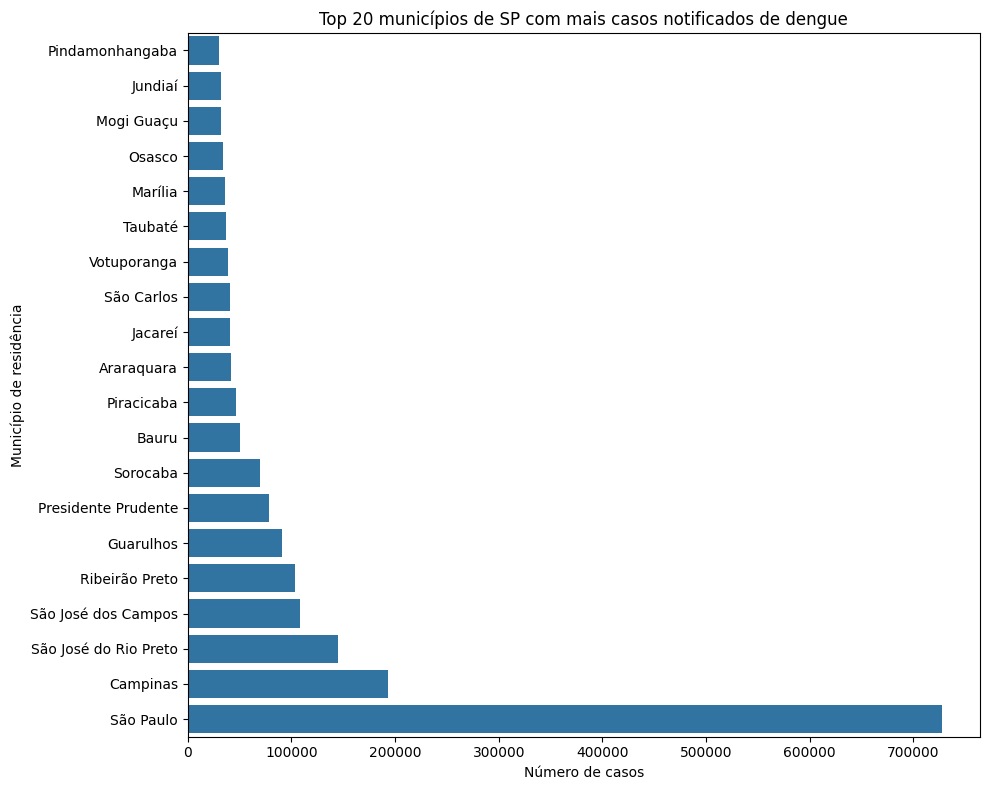

Gráfico (total de graves) salvo em: resultados/top_municipios_graves_sp_graves.png


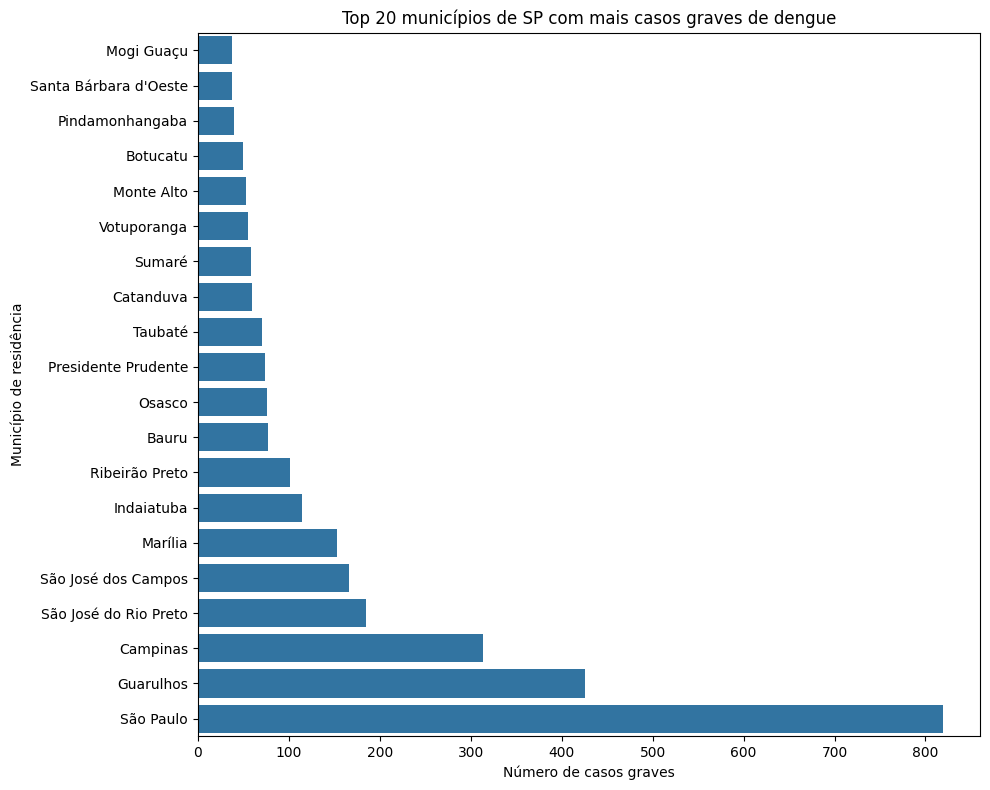

Gráfico (proporção de graves) salvo em: resultados/top_municipios_graves_sp_proporcao.png


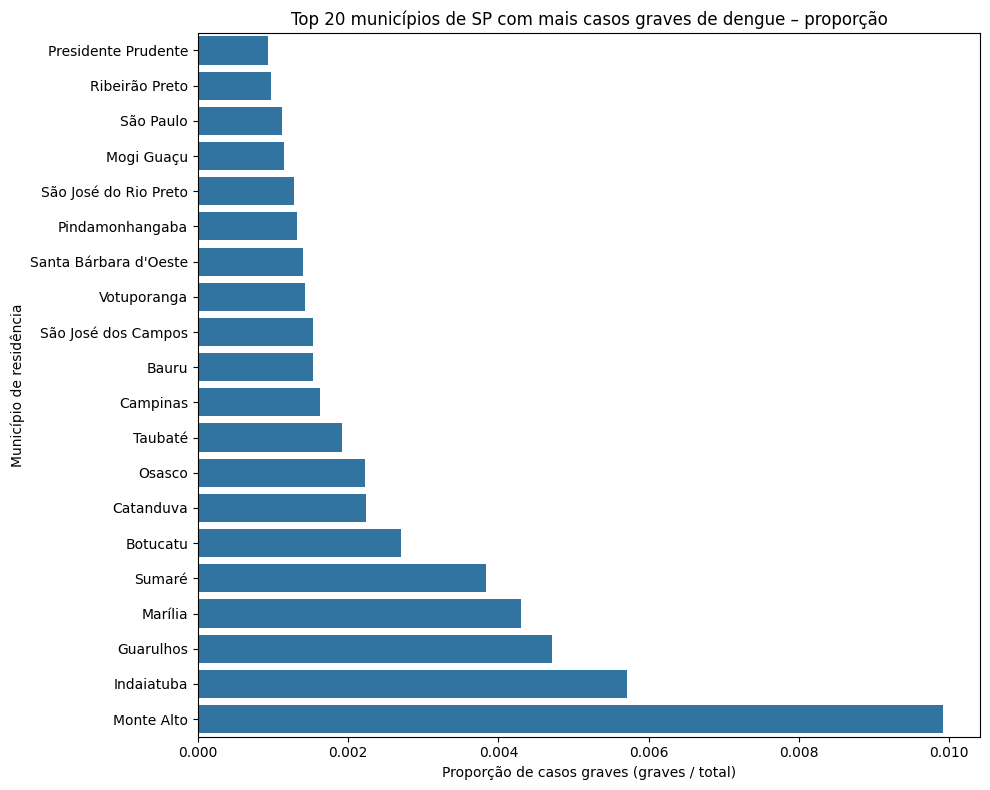

(   id_mn_resi_6         municipio_nome   casos
 0        355030              São Paulo  727805
 1        350950               Campinas  192951
 2        354980  São José do Rio Preto  144660
 3        354990    São José dos Campos  108479
 4        354340         Ribeirão Preto  103670
 5        351880              Guarulhos   90429
 6        354140    Presidente Prudente   78776
 7        355220               Sorocaba   69468
 8        350600                  Bauru   50292
 9        353870             Piracicaba   46769
 10       350320             Araraquara   42042
 11       352440                Jacareí   41029
 12       354890             São Carlos   40911
 13       355710            Votuporanga   38594
 14       355410                Taubaté   36595
 15       352900                Marília   35617
 16       353440                 Osasco   34196
 17       353070             Mogi Guaçu   32121
 18       352590                Jundiaí   31765
 19       353800        Pindamonhangaba 

In [ ]:
def executar_analise_municipios_sp(caminhos_zip, colunas_necessarias):
    dados = leitor_geral_especifico_zip(caminhos_zip, colunas_necessarias)
    dados = converter_datas(dados)
    dados = filtrar_classificados(dados)

    # 2) carrega mapa de municípios a partir do txt do IBGE
    mapa_mun_sp = carregar_mapa_municipios_sp_de_txt(
        "dados/municipios_sp_lista.txt"
    )

    # 3) tabelas
    tabela_mun = casos_por_municipio_sp(dados, mapa_mun_sp, uf_cod=35, top_n=20)
    tabela_mun_graves = casos_graves_por_municipio_sp(dados, mapa_mun_sp, uf_cod=35, top_n=20)

    print("Top 20 municípios de SP com mais casos:")
    print(tabela_mun.head(20))

    print("\nTop 20 municípios de SP com mais casos graves:")
    print(tabela_mun_graves.head(20))

    # gráfico de total de casos
    grafico_top_municipios_casos_sp(
        tabela_mun,
        titulo="Top 20 municípios de SP com mais casos notificados de dengue",
        caminho_saida="resultados/top_municipios_casos_sp.png",
    )

    # gráficos de casos graves
    grafico_top_municipios_graves_sp(
        tabela_mun_graves,
        titulo="Top 20 municípios de SP com mais casos graves de dengue",
        caminho_saida="resultados/top_municipios_graves_sp.png",
    )

    return tabela_mun, tabela_mun_graves


caminhos_zip = [
    "dados/DENGBR20.zip",
    "dados/DENGBR21.zip",
    "dados/DENGBR22.zip",
    "dados/DENGBR23.zip",
    "dados/DENGBR24.zip",
    "dados/DENGBR25.zip",
]

colunas_necessarias = [
    "DT_NOTIFIC",
    "SEM_NOT",
    "NU_ANO",
    "SG_UF_NOT",
    "DT_SIN_PRI",
    "NU_IDADE_N",
    "CS_SEXO",
    "CLASSI_FIN",
    "ID_MN_RESI",
    "MUNICIPIO"
]

executar_analise_municipios_sp(caminhos_zip, colunas_necessarias)
